# Fully Convolutional DenseNets for Semantic Segmentation

## Overview

* [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326)
* [CamVid site](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/)
* [CamVid dataset](https://github.com/mostafaizz/camvid)

### Classes

![](LabelsColorKey.jpg)

## Data

In [1]:
%matplotlib inline
import importlib
import utils; importlib.reload(utils)
from utils import segment_generator
from PIL import Image
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

In [2]:
PATH = '/home/mark/data/datasets/cv/camvid/'
label_path = PATH+'LabeledApproved_full/'
frames_path = PATH+'701_StillsRaw_full/'

In [3]:
fnames = glob(frames_path+'*.png'); len(fnames)

701

In [4]:
# Image.open(fnames[0])

In [5]:
lnames = [label_path+os.path.basename(fn)[:-4]+'_L.png' for fn in fnames]; len(lnames)

701

In [6]:
# Image.open(lnames[0])

### Image resizing

Images in the dataset vary in size and are generally quite large –> resize for training

In [7]:
image_size = (480, 360)

In [8]:
def resize_image(fn): return np.array(Image.open(fn).resize(image_size, Image.NEAREST))

In [9]:
images = np.stack([resize_image(fn) for fn in fnames])

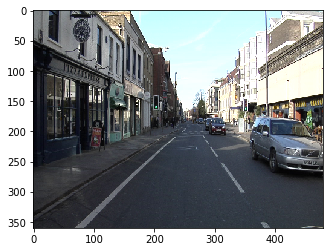

In [10]:
plt.imshow(images[0])

In [11]:
labels = np.stack([resize_image(fn) for fn in lnames])

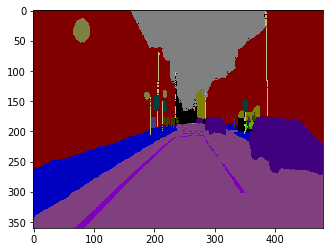

In [12]:
plt.imshow(labels[0])

In [13]:
images.shape, labels.shape

((701, 360, 480, 3), (701, 360, 480, 3))

In [14]:
n_imgs, rows, columns, channels = images.shape

### Image Preprocessing

The paper uses random cropping (224x224) and horizontal flipping for data augmentation for training

In [15]:
sg = segment_generator(images, labels, 4, train=False)

In [16]:
b_img, b_label = next(sg)

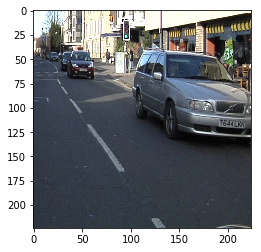

In [17]:
plt.imshow(b_img[0])

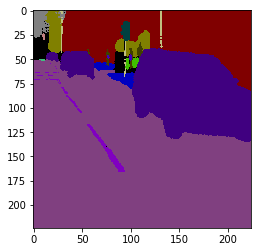

In [18]:
plt.imshow(b_label[0].reshape(224, 224, 3))

### Convert labels

Convert segmented targets into integers for classification.

The dataset contains a label_colors.txt file with a RGB - Entity mapping. Example:

    `64 128 64	Animal`

In [19]:
def parse_code(line):
    color, label = line.strip().split('\t')
    return tuple(int(o) for o in color.split(' ')), label

In [20]:
label_codes, label_names = zip(*[parse_code(line) for line in open(PATH+'label_colors.txt')])

In [21]:
label_codes, label_names = list(label_codes), list(label_names)

Map each color code (rgb) color to int

In [22]:
code2id = {v:k for k,v in enumerate(label_codes)}

Add code for erroneous pixel values

In [23]:
failed_code = len(label_codes)+1
label_codes.append((0,0,0))
label_names.append('UNK')

In [24]:
def convert_label(i):
    res = np.zeros((rows, columns), 'uint8')
    for j in range(rows):
        for k in range(columns):
            try: res[j, k] = code2id[tuple(labels[i, j, k])]
            except: res[j, k] = failed_code
    return res

In [25]:
def convert_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(convert_label, range(n_imgs)))

In [26]:
%time labels_int = convert_all_labels()

CPU times: user 244 ms, sys: 132 ms, total: 376 ms
Wall time: 1min 40s


Set erroneous pixels to zero

In [27]:
labels_int[labels_int==failed_code]=0

The paper uses a 367 frames for training, 101 frames for validation and 223 frames for test

In [28]:
train = images[:367]
train_labels = labels_int[:367]
val = images[367:468]
val_labels = labels_int[367:468]
test = images[468:]
test_labels = labels_int[468:]

In [29]:
train.shape, val.shape, test.shape

((367, 360, 480, 3), (101, 360, 480, 3), (233, 360, 480, 3))

In [30]:
n_classes = len(label_names); n_classes

33

## Model

In [31]:
from keras.layers import BatchNormalization, Activation, Dropout, Conv2D
from keras.layers import concatenate, MaxPool2D, Input, Reshape, Conv2DTranspose
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import TensorBoard, ModelCheckpoint

Using TensorFlow backend.


* initialized using HeUniform
* optimized using RMSProp w/ initial learning rate of 1e-3 and an exponential decay of 0.995
* regularized using weight decay of 1e-4 and a dropout rate of 0.2
* batch normalization is used with current batch statistics
* growth rate of 16
* batch size of 3
* 11 semantic classes (+ UNK)

### Components

#### Dense Block

In [32]:
def layer(x, filters, d_rate=0.2, w_decay=1e-4):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters,
               kernel_size=3,
               kernel_regularizer=l2(w_decay),
               kernel_initializer='he_uniform',
               padding='same')(x)
    x = Dropout(d_rate)(x)
    return x

In [33]:
def dense_block(x, growth_rate=16, n_layers=4, d_rate=0.2, w_decay=1e-4, name=0):
    for i in range(n_layers):
        l = layer(x, growth_rate, d_rate, w_decay)
        x = concatenate([x, l], name=f'{name}_{i}')
    return x

#### Transition Down

In [34]:
def trans_down(x, d_rate=0.2, w_decay=1e-4, name=0):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(x.get_shape().as_list()[-1],
               1,
               kernel_regularizer=l2(w_decay),
               kernel_initializer='he_uniform',
               padding='same')(x)
    x = Dropout(d_rate)(x)
    x = MaxPool2D()(x)
    return x

#### Down Path (Downsample)

In [35]:
def down_path(x, blocks, growth_rate, d_rate, w_decay):
    skips = []
    for i, n in enumerate(blocks):
        x, layers = dense_block(x, growth_rate, n, d_rate)
        skips.append(x)
        x = trans_down(x, d_rate, w_decay)
    return skips, layers

#### Transition Up

In [36]:
def trans_up(x, filters, w_decay=1e-4, name=0):
    x = Conv2DTranspose(filters,
                 3,
                 strides=(2,2),
                 padding='same',
                 kernel_regularizer=l2(w_decay),
                 kernel_initializer='he_uniform', name=name)(x)
    return x

#### Up Path (Upsample)

In [37]:
def up_path(added, skips, blocks, growth_rate, d_rate, w_decay):
    for i, n in enumerate(blocks):
        x = trans_up(added, w_decay)
        x = concatenate([x, skips[i]])
        x, layers = dense_block(x, growth_rate, n, d_rate, w_decay)
    return x

### Architecture

In [38]:
def reverse(a): return list(reversed(a))

In [39]:
def create_network(n_classes, inp, n_dense_blocks=6,
                   growth_rate=16, n_filters=48, n_layers_per_block=4, d_rate=0, w_decay=0):
    
    if type(n_layers_per_block) is list or type(n_layers_per_block) is tuple:
        blocks = list(n_layers_per_block)
    else:
        blocks = [n_layers_per_block] * n_dense_blocks
    
    # Downsample
    x = Conv2D(n_filters, 3, padding='same',kernel_initializer='he_uniform',
               kernel_regularizer=l2(w_decay))(inp)

    skips = []
    for i, n_layers in enumerate(blocks[:-1]):
        skips.append(dense_block(x, 16, n_layers, d_rate, w_decay, name=f'skip_{i}'))
        x = trans_down(skips[i], d_rate, w_decay, name=f'td_{i}')
    # Bottleneck
    x = dense_block(x, growth_rate, blocks[-1], d_rate, w_decay, name='bottleneck')
    
    # Upsample
    skips = reverse(skips)
    for i, n_layers in enumerate(reverse(blocks[:-1])):
        index = i + len(blocks)
        x = trans_up(x, n_layers*growth_rate, w_decay, name=f'tu_{i}')
        x = concatenate([x, skips[i]])
        x = dense_block(x, growth_rate, n_layers, d_rate, w_decay, index)
    
    x = Conv2D(n_classes, 1, padding='same', kernel_initializer='he_uniform',
               kernel_regularizer=l2(w_decay))(x)
    x = Reshape((-1, n_classes))(x)
    x = Activation('softmax')(x)
    return x

### Train

In [40]:
input_shape = (224, 224, 3)

In [41]:
img_input = Input(shape=input_shape)

In [42]:
n_layers_per_block = [4, 5, 7, 10, 12, 15]

In [43]:
x = create_network(n_classes, img_input, n_layers_per_block=n_layers_per_block, d_rate=0.2, w_decay=1e-4)

In [44]:
model = Model(img_input, x)

In [45]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 224, 224, 48)  1344        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 224, 224, 48)  192         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 224, 224, 48)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [46]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(1e-3), metrics=['accuracy'])

In [47]:
gen = segment_generator(train, train_labels, 3, train=True)

In [48]:
gen_val = segment_generator(val, val_labels, 3, train=False)

In [ ]:
parms = { 'verbose': 2, 'callbacks': [TensorBoard(),
                                    TQDMNotebookCallback()]}

In [ ]:
model.fit_generator(gen, len(train_labels), epochs=100,
                    validation_data=gen_val, validation_steps=len(val_labels), **parms)

HBox(children=(IntProgress(value=0, description='Training: '), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0: ', max=367), HTML(value='')))

Epoch 1/100
185s - loss: 10.7709 - acc: 0.3552 - val_loss: 13.7025 - val_acc: 0.1567


HBox(children=(IntProgress(value=0, description='Epoch 1: ', max=367), HTML(value='')))

Epoch 2/100
177s - loss: 9.5172 - acc: 0.4170 - val_loss: 13.5774 - val_acc: 0.1565


HBox(children=(IntProgress(value=0, description='Epoch 2: ', max=367), HTML(value='')))

Epoch 3/100
177s - loss: 8.7594 - acc: 0.4505 - val_loss: 6.6272 - val_acc: 0.1448


HBox(children=(IntProgress(value=0, description='Epoch 3: ', max=367), HTML(value='')))

Epoch 4/100
177s - loss: 3.4585 - acc: 0.6242 - val_loss: 2.5449 - val_acc: 0.6420


HBox(children=(IntProgress(value=0, description='Epoch 4: ', max=367), HTML(value='')))

Epoch 5/100
177s - loss: 2.6460 - acc: 0.6530 - val_loss: 2.6907 - val_acc: 0.3919


HBox(children=(IntProgress(value=0, description='Epoch 5: ', max=367), HTML(value='')))

Epoch 6/100
177s - loss: 2.2067 - acc: 0.6792 - val_loss: 2.1966 - val_acc: 0.6112


HBox(children=(IntProgress(value=0, description='Epoch 6: ', max=367), HTML(value='')))

Epoch 7/100
177s - loss: 1.8189 - acc: 0.7014 - val_loss: 1.7870 - val_acc: 0.5817


HBox(children=(IntProgress(value=0, description='Epoch 7: ', max=367), HTML(value='')))

Epoch 8/100
177s - loss: 1.5886 - acc: 0.7129 - val_loss: 1.8398 - val_acc: 0.6169


HBox(children=(IntProgress(value=0, description='Epoch 8: ', max=367), HTML(value='')))

Epoch 9/100
177s - loss: 1.3964 - acc: 0.7380 - val_loss: 1.3277 - val_acc: 0.7075


HBox(children=(IntProgress(value=0, description='Epoch 9: ', max=367), HTML(value='')))

Epoch 10/100
176s - loss: 1.3319 - acc: 0.7433 - val_loss: 1.2023 - val_acc: 0.7246


HBox(children=(IntProgress(value=0, description='Epoch 10: ', max=367), HTML(value='')))

Epoch 11/100
177s - loss: 1.2184 - acc: 0.7607 - val_loss: 1.6725 - val_acc: 0.5726


HBox(children=(IntProgress(value=0, description='Epoch 11: ', max=367), HTML(value='')))

Epoch 12/100
177s - loss: 1.1190 - acc: 0.7745 - val_loss: 1.2545 - val_acc: 0.7029


HBox(children=(IntProgress(value=0, description='Epoch 12: ', max=367), HTML(value='')))

Epoch 13/100
177s - loss: 1.0308 - acc: 0.7809 - val_loss: 1.2018 - val_acc: 0.6893


HBox(children=(IntProgress(value=0, description='Epoch 13: ', max=367), HTML(value='')))

Epoch 14/100
177s - loss: 0.9422 - acc: 0.7931 - val_loss: 0.9906 - val_acc: 0.7552


HBox(children=(IntProgress(value=0, description='Epoch 14: ', max=367), HTML(value='')))

Epoch 15/100
177s - loss: 0.8835 - acc: 0.8015 - val_loss: 0.9551 - val_acc: 0.7707


HBox(children=(IntProgress(value=0, description='Epoch 15: ', max=367), HTML(value='')))

Epoch 16/100
176s - loss: 0.8360 - acc: 0.8078 - val_loss: 1.3932 - val_acc: 0.6273


HBox(children=(IntProgress(value=0, description='Epoch 16: ', max=367), HTML(value='')))

Epoch 17/100
177s - loss: 0.8198 - acc: 0.8111 - val_loss: 0.8737 - val_acc: 0.7957


HBox(children=(IntProgress(value=0, description='Epoch 17: ', max=367), HTML(value='')))

Epoch 18/100
177s - loss: 0.8020 - acc: 0.8139 - val_loss: 0.9201 - val_acc: 0.7772


HBox(children=(IntProgress(value=0, description='Epoch 18: ', max=367), HTML(value='')))

Epoch 19/100
177s - loss: 0.7798 - acc: 0.8212 - val_loss: 1.2010 - val_acc: 0.6932


HBox(children=(IntProgress(value=0, description='Epoch 19: ', max=367), HTML(value='')))

Epoch 20/100
177s - loss: 0.7562 - acc: 0.8242 - val_loss: 0.9382 - val_acc: 0.7816


HBox(children=(IntProgress(value=0, description='Epoch 20: ', max=367), HTML(value='')))

Epoch 21/100
177s - loss: 0.7400 - acc: 0.8297 - val_loss: 0.9964 - val_acc: 0.7445


HBox(children=(IntProgress(value=0, description='Epoch 21: ', max=367), HTML(value='')))

Epoch 22/100
177s - loss: 0.7282 - acc: 0.8312 - val_loss: 0.9453 - val_acc: 0.7586


HBox(children=(IntProgress(value=0, description='Epoch 22: ', max=367), HTML(value='')))

Epoch 23/100
177s - loss: 0.7139 - acc: 0.8338 - val_loss: 0.9595 - val_acc: 0.7630


HBox(children=(IntProgress(value=0, description='Epoch 23: ', max=367), HTML(value='')))

Epoch 24/100
177s - loss: 0.7145 - acc: 0.8335 - val_loss: 0.9275 - val_acc: 0.7695


HBox(children=(IntProgress(value=0, description='Epoch 24: ', max=367), HTML(value='')))

Epoch 25/100
177s - loss: 0.6868 - acc: 0.8401 - val_loss: 1.4287 - val_acc: 0.5791


HBox(children=(IntProgress(value=0, description='Epoch 25: ', max=367), HTML(value='')))

Epoch 26/100
177s - loss: 0.6973 - acc: 0.8371 - val_loss: 0.9278 - val_acc: 0.7697


HBox(children=(IntProgress(value=0, description='Epoch 26: ', max=367), HTML(value='')))

Epoch 27/100
177s - loss: 0.6780 - acc: 0.8432 - val_loss: 0.7664 - val_acc: 0.8157


HBox(children=(IntProgress(value=0, description='Epoch 27: ', max=367), HTML(value='')))

Epoch 28/100
177s - loss: 0.6704 - acc: 0.8446 - val_loss: 1.0800 - val_acc: 0.7072


HBox(children=(IntProgress(value=0, description='Epoch 28: ', max=367), HTML(value='')))

Epoch 29/100
177s - loss: 0.6644 - acc: 0.8463 - val_loss: 0.8123 - val_acc: 0.8047


HBox(children=(IntProgress(value=0, description='Epoch 29: ', max=367), HTML(value='')))

Epoch 30/100
177s - loss: 0.6553 - acc: 0.8484 - val_loss: 1.0039 - val_acc: 0.7439


HBox(children=(IntProgress(value=0, description='Epoch 30: ', max=367), HTML(value='')))

Epoch 31/100
177s - loss: 0.6512 - acc: 0.8478 - val_loss: 1.2179 - val_acc: 0.6780


HBox(children=(IntProgress(value=0, description='Epoch 31: ', max=367), HTML(value='')))

Epoch 32/100
177s - loss: 0.6314 - acc: 0.8532 - val_loss: 1.2338 - val_acc: 0.6929


HBox(children=(IntProgress(value=0, description='Epoch 32: ', max=367), HTML(value='')))

Epoch 33/100
178s - loss: 0.6444 - acc: 0.8492 - val_loss: 0.8966 - val_acc: 0.7731


HBox(children=(IntProgress(value=0, description='Epoch 33: ', max=367), HTML(value='')))

Epoch 34/100
178s - loss: 0.6354 - acc: 0.8516 - val_loss: 1.0327 - val_acc: 0.7321


HBox(children=(IntProgress(value=0, description='Epoch 34: ', max=367), HTML(value='')))

Epoch 35/100
178s - loss: 0.6227 - acc: 0.8550 - val_loss: 0.7439 - val_acc: 0.8201


HBox(children=(IntProgress(value=0, description='Epoch 35: ', max=367), HTML(value='')))

Epoch 36/100
178s - loss: 0.6256 - acc: 0.8543 - val_loss: 1.0625 - val_acc: 0.7219


HBox(children=(IntProgress(value=0, description='Epoch 36: ', max=367), HTML(value='')))

Epoch 37/100
178s - loss: 0.6137 - acc: 0.8576 - val_loss: 1.0729 - val_acc: 0.6981


HBox(children=(IntProgress(value=0, description='Epoch 37: ', max=367), HTML(value='')))

Epoch 38/100
178s - loss: 0.6292 - acc: 0.8537 - val_loss: 0.9720 - val_acc: 0.7629


HBox(children=(IntProgress(value=0, description='Epoch 38: ', max=367), HTML(value='')))

Epoch 39/100
177s - loss: 0.6113 - acc: 0.8579 - val_loss: 0.9098 - val_acc: 0.7699


HBox(children=(IntProgress(value=0, description='Epoch 39: ', max=367), HTML(value='')))

Epoch 40/100
177s - loss: 0.6010 - acc: 0.8609 - val_loss: 0.7997 - val_acc: 0.8024


HBox(children=(IntProgress(value=0, description='Epoch 44: ', max=367), HTML(value='')))

Epoch 45/100
178s - loss: 0.5912 - acc: 0.8623 - val_loss: 1.0013 - val_acc: 0.7430


HBox(children=(IntProgress(value=0, description='Epoch 45: ', max=367), HTML(value='')))

Epoch 46/100
178s - loss: 0.5831 - acc: 0.8643 - val_loss: 1.3304 - val_acc: 0.6353


HBox(children=(IntProgress(value=0, description='Epoch 46: ', max=367), HTML(value='')))

Epoch 47/100
178s - loss: 0.5927 - acc: 0.8623 - val_loss: 0.7393 - val_acc: 0.8188


HBox(children=(IntProgress(value=0, description='Epoch 47: ', max=367), HTML(value='')))

Epoch 48/100
177s - loss: 0.5808 - acc: 0.8658 - val_loss: 0.8856 - val_acc: 0.7779


HBox(children=(IntProgress(value=0, description='Epoch 48: ', max=367), HTML(value='')))

Epoch 49/100
178s - loss: 0.5860 - acc: 0.8629 - val_loss: 0.8175 - val_acc: 0.7959


HBox(children=(IntProgress(value=0, description='Epoch 49: ', max=367), HTML(value='')))

Epoch 50/100
178s - loss: 0.5804 - acc: 0.8660 - val_loss: 0.9683 - val_acc: 0.7630


HBox(children=(IntProgress(value=0, description='Epoch 50: ', max=367), HTML(value='')))

Epoch 51/100
178s - loss: 0.5764 - acc: 0.8663 - val_loss: 0.8229 - val_acc: 0.7963


HBox(children=(IntProgress(value=0, description='Epoch 51: ', max=367), HTML(value='')))

Epoch 52/100
177s - loss: 0.5722 - acc: 0.8673 - val_loss: 0.9620 - val_acc: 0.7589


HBox(children=(IntProgress(value=0, description='Epoch 52: ', max=367), HTML(value='')))

Epoch 53/100
178s - loss: 0.5808 - acc: 0.8655 - val_loss: 0.8022 - val_acc: 0.8080


HBox(children=(IntProgress(value=0, description='Epoch 53: ', max=367), HTML(value='')))

Epoch 54/100
177s - loss: 0.5665 - acc: 0.8690 - val_loss: 0.7249 - val_acc: 0.8240


HBox(children=(IntProgress(value=0, description='Epoch 54: ', max=367), HTML(value='')))

Epoch 55/100
178s - loss: 0.5787 - acc: 0.8653 - val_loss: 0.9338 - val_acc: 0.7687


HBox(children=(IntProgress(value=0, description='Epoch 55: ', max=367), HTML(value='')))

Epoch 56/100
177s - loss: 0.5660 - acc: 0.8691 - val_loss: 0.8201 - val_acc: 0.7975


HBox(children=(IntProgress(value=0, description='Epoch 56: ', max=367), HTML(value='')))

Epoch 57/100
178s - loss: 0.5675 - acc: 0.8681 - val_loss: 0.7506 - val_acc: 0.8243


HBox(children=(IntProgress(value=0, description='Epoch 57: ', max=367), HTML(value='')))

Epoch 58/100
178s - loss: 0.5620 - acc: 0.8705 - val_loss: 0.8280 - val_acc: 0.7957


HBox(children=(IntProgress(value=0, description='Epoch 58: ', max=367), HTML(value='')))

Epoch 59/100
177s - loss: 0.5625 - acc: 0.8693 - val_loss: 0.9653 - val_acc: 0.7654


HBox(children=(IntProgress(value=0, description='Epoch 59: ', max=367), HTML(value='')))

Epoch 60/100
177s - loss: 0.5696 - acc: 0.8686 - val_loss: 0.7925 - val_acc: 0.8136


HBox(children=(IntProgress(value=0, description='Epoch 60: ', max=367), HTML(value='')))

Epoch 61/100
177s - loss: 0.5608 - acc: 0.8707 - val_loss: 0.7775 - val_acc: 0.8088


HBox(children=(IntProgress(value=0, description='Epoch 61: ', max=367), HTML(value='')))

Epoch 62/100
178s - loss: 0.5527 - acc: 0.8724 - val_loss: 1.2481 - val_acc: 0.6511


HBox(children=(IntProgress(value=0, description='Epoch 62: ', max=367), HTML(value='')))

Epoch 63/100
178s - loss: 0.5591 - acc: 0.8707 - val_loss: 0.8435 - val_acc: 0.7930


HBox(children=(IntProgress(value=0, description='Epoch 63: ', max=367), HTML(value='')))

Epoch 64/100
177s - loss: 0.5441 - acc: 0.8753 - val_loss: 0.7880 - val_acc: 0.8156


HBox(children=(IntProgress(value=0, description='Epoch 64: ', max=367), HTML(value='')))

Epoch 65/100
178s - loss: 0.5555 - acc: 0.8720 - val_loss: 1.2174 - val_acc: 0.6869


HBox(children=(IntProgress(value=0, description='Epoch 65: ', max=367), HTML(value='')))

Epoch 66/100
178s - loss: 0.5577 - acc: 0.8713 - val_loss: 0.8447 - val_acc: 0.7823


HBox(children=(IntProgress(value=0, description='Epoch 66: ', max=367), HTML(value='')))

Epoch 67/100
177s - loss: 0.5596 - acc: 0.8709 - val_loss: 0.7496 - val_acc: 0.8271


HBox(children=(IntProgress(value=0, description='Epoch 67: ', max=367), HTML(value='')))

Epoch 68/100
177s - loss: 0.5481 - acc: 0.8735 - val_loss: 0.8944 - val_acc: 0.7757


HBox(children=(IntProgress(value=0, description='Epoch 68: ', max=367), HTML(value='')))

Epoch 69/100
177s - loss: 0.5585 - acc: 0.8713 - val_loss: 0.9024 - val_acc: 0.7803


HBox(children=(IntProgress(value=0, description='Epoch 69: ', max=367), HTML(value='')))

Epoch 70/100
177s - loss: 0.5474 - acc: 0.8744 - val_loss: 0.7860 - val_acc: 0.8185


HBox(children=(IntProgress(value=0, description='Epoch 70: ', max=367), HTML(value='')))

Epoch 71/100
177s - loss: 0.5384 - acc: 0.8764 - val_loss: 0.8132 - val_acc: 0.8001


HBox(children=(IntProgress(value=0, description='Epoch 71: ', max=367), HTML(value='')))

Epoch 72/100
177s - loss: 0.5351 - acc: 0.8767 - val_loss: 0.9414 - val_acc: 0.7570


HBox(children=(IntProgress(value=0, description='Epoch 72: ', max=367), HTML(value='')))

Epoch 73/100
178s - loss: 0.5401 - acc: 0.8767 - val_loss: 0.7892 - val_acc: 0.8057


HBox(children=(IntProgress(value=0, description='Epoch 73: ', max=367), HTML(value='')))

Epoch 74/100
177s - loss: 0.5484 - acc: 0.8736 - val_loss: 0.9722 - val_acc: 0.7681


HBox(children=(IntProgress(value=0, description='Epoch 74: ', max=367), HTML(value='')))

Epoch 75/100
177s - loss: 0.5298 - acc: 0.8784 - val_loss: 0.8885 - val_acc: 0.7847


HBox(children=(IntProgress(value=0, description='Epoch 75: ', max=367), HTML(value='')))

Epoch 76/100
176s - loss: 0.5393 - acc: 0.8761 - val_loss: 0.8108 - val_acc: 0.8009


HBox(children=(IntProgress(value=0, description='Epoch 76: ', max=367), HTML(value='')))

Epoch 77/100
177s - loss: 0.5321 - acc: 0.8767 - val_loss: 0.9209 - val_acc: 0.7704


HBox(children=(IntProgress(value=0, description='Epoch 77: ', max=367), HTML(value='')))

Epoch 78/100
177s - loss: 0.5441 - acc: 0.8743 - val_loss: 0.7691 - val_acc: 0.8114


HBox(children=(IntProgress(value=0, description='Epoch 78: ', max=367), HTML(value='')))

Epoch 79/100
178s - loss: 0.5260 - acc: 0.8786 - val_loss: 0.9260 - val_acc: 0.7687


HBox(children=(IntProgress(value=0, description='Epoch 79: ', max=367), HTML(value='')))

Epoch 80/100
177s - loss: 0.5322 - acc: 0.8769 - val_loss: 1.0597 - val_acc: 0.7226


HBox(children=(IntProgress(value=0, description='Epoch 80: ', max=367), HTML(value='')))

Epoch 81/100
176s - loss: 0.5411 - acc: 0.8749 - val_loss: 0.9937 - val_acc: 0.7565


HBox(children=(IntProgress(value=0, description='Epoch 81: ', max=367), HTML(value='')))

Epoch 82/100
176s - loss: 0.5271 - acc: 0.8778 - val_loss: 0.7888 - val_acc: 0.8093


HBox(children=(IntProgress(value=0, description='Epoch 82: ', max=367), HTML(value='')))

Epoch 83/100
177s - loss: 0.5308 - acc: 0.8771 - val_loss: 0.9454 - val_acc: 0.7603


HBox(children=(IntProgress(value=0, description='Epoch 83: ', max=367), HTML(value='')))

Epoch 84/100
177s - loss: 0.5279 - acc: 0.8778 - val_loss: 0.7978 - val_acc: 0.8034


HBox(children=(IntProgress(value=0, description='Epoch 84: ', max=367), HTML(value='')))

Epoch 85/100
177s - loss: 0.5330 - acc: 0.8768 - val_loss: 0.9196 - val_acc: 0.7729


HBox(children=(IntProgress(value=0, description='Epoch 85: ', max=367), HTML(value='')))

Epoch 86/100
177s - loss: 0.5255 - acc: 0.8789 - val_loss: 1.8418 - val_acc: 0.4678


HBox(children=(IntProgress(value=0, description='Epoch 86: ', max=367), HTML(value='')))

Epoch 87/100
177s - loss: 0.5275 - acc: 0.8777 - val_loss: 1.1530 - val_acc: 0.6792


HBox(children=(IntProgress(value=0, description='Epoch 87: ', max=367), HTML(value='')))

Epoch 88/100
177s - loss: 0.5286 - acc: 0.8776 - val_loss: 0.9044 - val_acc: 0.7674


HBox(children=(IntProgress(value=0, description='Epoch 88: ', max=367), HTML(value='')))

Epoch 89/100
177s - loss: 0.5337 - acc: 0.8774 - val_loss: 0.9508 - val_acc: 0.7649


HBox(children=(IntProgress(value=0, description='Epoch 89: ', max=367), HTML(value='')))

Epoch 90/100
177s - loss: 0.5398 - acc: 0.8747 - val_loss: 1.1101 - val_acc: 0.6993


HBox(children=(IntProgress(value=0, description='Epoch 90: ', max=367), HTML(value='')))

Epoch 91/100
177s - loss: 0.5331 - acc: 0.8770 - val_loss: 0.8529 - val_acc: 0.7875


HBox(children=(IntProgress(value=0, description='Epoch 91: ', max=367), HTML(value='')))

Epoch 92/100
177s - loss: 0.5226 - acc: 0.8798 - val_loss: 0.9795 - val_acc: 0.7437


HBox(children=(IntProgress(value=0, description='Epoch 92: ', max=367), HTML(value='')))

Epoch 93/100
177s - loss: 0.5261 - acc: 0.8791 - val_loss: 0.8903 - val_acc: 0.7789


HBox(children=(IntProgress(value=0, description='Epoch 93: ', max=367), HTML(value='')))

Epoch 94/100
177s - loss: 0.5217 - acc: 0.8793 - val_loss: 1.5656 - val_acc: 0.5465


HBox(children=(IntProgress(value=0, description='Epoch 94: ', max=367), HTML(value='')))

Epoch 95/100
177s - loss: 0.5220 - acc: 0.8797 - val_loss: 1.4283 - val_acc: 0.5936


HBox(children=(IntProgress(value=0, description='Epoch 95: ', max=367), HTML(value='')))

Epoch 96/100
177s - loss: 0.5178 - acc: 0.8807 - val_loss: 1.3402 - val_acc: 0.6531


HBox(children=(IntProgress(value=0, description='Epoch 96: ', max=367), HTML(value='')))

Epoch 97/100
177s - loss: 0.5112 - acc: 0.8822 - val_loss: 1.2317 - val_acc: 0.6818


HBox(children=(IntProgress(value=0, description='Epoch 97: ', max=367), HTML(value='')))

Epoch 98/100
177s - loss: 0.5204 - acc: 0.8800 - val_loss: 0.9453 - val_acc: 0.7697


HBox(children=(IntProgress(value=0, description='Epoch 98: ', max=367), HTML(value='')))

Epoch 99/100
177s - loss: 0.5193 - acc: 0.8806 - val_loss: 0.8543 - val_acc: 0.7912


HBox(children=(IntProgress(value=0, description='Epoch 99: ', max=367), HTML(value='')))

Epoch 100/100
177s - loss: 0.5136 - acc: 0.8824 - val_loss: 1.2639 - val_acc: 0.6687



In [ ]:
model.save_weights('./models/fc-dense-100.h5')